In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Подготовка данных

Сразу хочется исправить опечатку в названии поля `Helthcare_2`.

In [3]:
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Healthcare_2', 'Shops_1', 'Shops_2', 'Price']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В двух полях есть пропущенные данные. Три поля имеют тип `object` вместо числового.

In [5]:
data.select_dtypes(include=['object']).describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


Начнем чистку данных с поля `LifeSquare`.

In [6]:
data['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

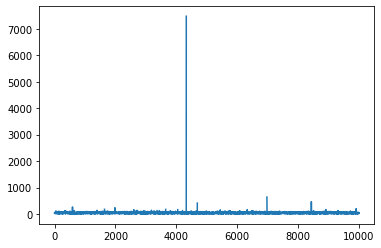

In [7]:
data['LifeSquare'].plot()

Здесь виден явный выброс в интервале между 4000 и 5000 элементов. В остальных случаях разброс данных небольшой.

In [8]:
data[['LifeSquare']].sort_values(by='LifeSquare', ascending=False, na_position='last')

,LifeSquare
4328,7480.592129
6977,638.163193
8437,461.463614
4690,410.639749
590,263.542020
...,...
9985,NaN
9986,NaN
9987,NaN
9994,NaN


Удалим это наблюдение и заменим пропущенные значения этого поля на среднее значение.

In [9]:
data = data.drop(4328)

In [10]:
data[['LifeSquare']] = data[['LifeSquare']].fillna(data[['LifeSquare']].mean())

Теперь почистим поле `Healthcare_1`.

In [11]:
data[['Healthcare_1']].describe()

,Healthcare_1
count,5202.000000
mean,1142.904460
std,1021.517264
min,0.000000
25%,350.000000
50%,900.000000
75%,1548.000000
max,4849.000000


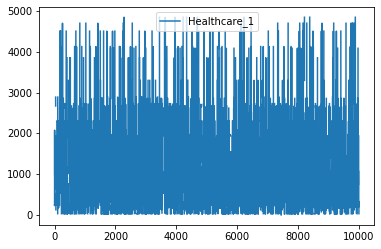

In [12]:
data[['Healthcare_1']].plot()

Данные этого поля выглядят как шум. Модель работает лучше, если заменить эти данные на среднее значение.

In [13]:
data[['Healthcare_1']] = data[['Healthcare_1']].fillna(data[['Healthcare_1']].mean())

Теперь перейдем к категориальным полям.

In [14]:
data['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

Во всех трёх полях есть только 2 уникальных значения: A и B. Заменим их на числовые.

In [15]:
data['Ecology_2'] = data['Ecology_2'].map({'A':0, 'B':1})
data['Ecology_3'] = data['Ecology_3'].map({'A':0, 'B':1})
data['Shops_2'] = data['Shops_2'].map({'A':0, 'B':1})

Чистка данных завершена. Приступим к обучению моделей.

### Создание модели

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, 0:-1], 
                                                    data.iloc[:, -1], 
                                                    test_size=0.25, 
                                                    random_state=40)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled)

Скалирование данных в итоге не пригодилось, так как модели линейной регрессии показали плохой результат, а для случайного леса скалирование не нужно.

In [18]:
x_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-1.065330,-0.084478,1.317537,1.278488,0.730389,0.109149,-0.669029,0.500774,-0.264486,-0.132404,0.099148,0.16468,-0.096780,-0.192264,-0.213779,-0.002312,1.128392,-0.255927,0.303109
1,-0.817019,-0.221649,1.317537,2.988290,1.672670,0.230996,-0.477670,0.204953,1.249752,-0.689801,0.099148,0.16468,-0.039867,-0.243407,-0.338119,-0.148169,-0.216033,-0.669681,0.303109
2,-1.172542,-1.021814,0.130440,0.467746,0.005623,-0.165007,0.096407,0.648685,-0.426726,1.065738,0.099148,0.16468,-1.121217,-0.945430,-0.338119,-0.824894,-0.888246,-0.876557,0.303109
3,1.093889,-0.130202,0.130440,0.318862,0.162321,0.109149,2.584073,1.831971,1.736471,0.663706,0.099148,0.16468,-0.096780,-0.035344,-0.089438,-0.002312,1.128392,-0.462804,0.303109
4,-0.673044,-1.136123,-1.056658,-0.694169,0.005623,0.109149,1.244560,0.648685,1.628311,-0.935648,0.099148,0.16468,-1.348870,-1.269747,-0.338119,-0.002312,-0.888246,-0.669681,0.303109


Модели линейной регрессии показали слишком низкий критерий оценки качества. Поэтому сразу перейду к использованию RandomForestRegressor. После использования GridSearch, я выяснил что лучшие параметры это max_depth=9, max_features=8 и n_estimators=150.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'n_estimators': [150, 200, 250],
#     'max_features': np.arange(5, 9),
#     'max_depth': np.arange(5, 10),
# }

# model = GridSearchCV(
#     estimator=RandomForestRegressor(),
#     param_grid=parameters,
#     scoring='neg_mean_squared_error',
#     cv=5,
# )

# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# r2_score(y_test, y_pred)

In [20]:
model = RandomForestRegressor(max_depth=9, 
                              max_features=8, 
                              n_estimators=150, 
                              random_state=40)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.7140524375566016

### Проверка модели на тестовых данных

In [21]:
data_test = pd.read_csv('test.csv')
data_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [22]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Опечатка в названии поля ещё присутсвует. Изменю названия полей тестовых данных.

In [23]:
data_test.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Healthcare_2', 'Shops_1', 'Shops_2']

Пропущенные значения в тестовых данных меняю на средние значения из тренировочных. Категориальные поля перевожу в числовые.

In [24]:
data_test[['LifeSquare']] = data_test[['LifeSquare']].fillna(data[['LifeSquare']].mean())
data_test[['Healthcare_1']] = data_test['Healthcare_1'].fillna(data['Healthcare_1'].mean())

In [25]:
data_test['Ecology_2'] = data_test['Ecology_2'].map({'A':0, 'B':1})
data_test['Ecology_3'] = data_test['Ecology_3'].map({'A':0, 'B':1})
data_test['Shops_2'] = data_test['Shops_2'].map({'A':0, 'B':1})

Делаем предсказания и выгружаем их в файл.

In [26]:
predictions = model.predict(data_test)
predictions

array([174616.754884  , 206395.60429335, 216053.45424119, ...,
       325269.80004602, 204231.07117106, 178566.48315466])

In [27]:
results = pd.DataFrame()
results['Id'] = data_test['Id']
results['Price'] = predictions

In [28]:
results.head()

,Id,Price
0,725,174616.754884
1,15856,206395.604293
2,5480,216053.454241
3,15664,341477.773004
4,14275,135757.045291


In [29]:
results.to_csv('SPopov_predictions.csv', index=False)